In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import importlib
import sys

# Determine the environment and import preprocessing module accordingly
def is_kaggle():
    return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle():
    print("Running on Kaggle")
    # Assuming 'preprocessing.py' and other scripts are in '/kaggle/input'
    kaggle_input_path = '/kaggle/usr/lib'
    sys.path.append(kaggle_input_path)
    
    import models_py.models_py as models
    import utils_py.utils_py as utils
   
    
    # Install missing libraries on kaggle
    ! pip install torchsummary
    ! pip install mlflow
else:
    print("Running locally")
    import scripts.models as models
    import scripts.utils as utils
    
    
    
# Reload the module (if necessary)
importlib.reload(models)
importlib.reload(utils)

# Other imports
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchsummary
import torch.optim as optim
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import torch

Running on Kaggle
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not inst

In [2]:
device = utils.use_GPU()

model = models.StormColorModel()

#model.load_state_dict(torch.load("/kaggle/input/colorization_edition/pytorch/6epochs/1/SSL_n5_ep.pth"))

model.to(device);

CUDA is available!  Training on GPU ...
cuda:0


In [3]:
torchsummary.summary(model, (1, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]             640
         LeakyReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 16, 56, 56]           1,040
         LeakyReLU-5           [-1, 16, 56, 56]               0
       BatchNorm2d-6           [-1, 16, 56, 56]              32
            Conv2d-7           [-1, 64, 56, 56]           1,088
         LeakyReLU-8           [-1, 64, 56, 56]               0
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           Conv2d-10           [-1, 64, 56, 56]           9,280
        LeakyReLU-11           [-1, 64, 56, 56]               0
      BatchNorm2d-12           [-1, 64, 56, 56]             128
        FireStorm-13          [-1, 128, 56, 56]               0
           Conv2d-14           [-1, 16,

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        grayscale_image = transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
        
        return grayscale_image, image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageDataset(image_folder="/kaggle/input/foodsslimages/images", transform=transform)

torch.manual_seed(42)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [5]:
# stepsize history
# ep: 1 lr 1e-5
# ep: 2 lr 1e-5
# ep. 3 lr 5e-6
# ep: 4 lr 5e-6
# ep: 5 lr 2.5e-6
# ep: 6 lr 2.5e-6

In [6]:
# Initialize model, loss function, and optimizer

step_size = 2
gamma = 0.5


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

class CustomExpLoss(nn.Module):
    def __init__(self):
        super(CustomExpLoss, self).__init__()
    
    def forward(self, output, target):
        weight = 1 + (2 * torch.exp(target / 255.0))
        loss = weight * (output - target) ** 2
        return loss.mean()

criterion = CustomExpLoss()

In [7]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20, run_name = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    patience = 5
    ind_pat = 0
    best_model = model
    best_val_loss = np.inf
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", optimizer.param_groups[0]['lr'])
        mlflow.log_param("batch_size", train_dataloader.batch_size)
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            # Use tqdm for the progress bar
            progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
            
            ind_prog = 1
            for grayscale, color in progress_bar:
                grayscale = grayscale.to(device)
                color = color.to(device)

                optimizer.zero_grad()
                outputs = model(grayscale)
                loss = criterion(outputs, color)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * grayscale.size(0)

                # Update progress bar with the current loss
                progress_bar.set_postfix(loss=running_loss/ind_prog)
                ind_prog+=1
                
            epoch_loss = running_loss / len(train_dataloader.dataset)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
            mlflow.log_metric("train_loss", epoch_loss, step=epoch)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for grayscale, color in val_dataloader:
                    grayscale = grayscale.to(device)
                    color = color.to(device)

                    outputs = model(grayscale)
                    loss = criterion(outputs, color)

                    val_loss += loss.item() * grayscale.size(0)

            val_loss /= len(val_dataloader.dataset)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                ind_pat = 0
            else:
                ind_pat+=1
            
            torch.save(model.state_dict(),f"SSL_n{epoch +6}_ep.pth")
                
        # Log the model at the end of the run
        mlflow.pytorch.log_model(model, "colorization_model")

In [8]:
# Start training
train(model = model, 
      train_dataloader = train_dataloader, 
      val_dataloader= test_dataloader, 
      criterion = criterion, 
      optimizer = optimizer, 
      num_epochs=6, 
      run_name="colorization_model_low_lr")

Epoch 1/6: 100%|██████████| 805/805 [04:25<00:00,  3.03it/s, loss=238]

Epoch 1/6, Training Loss: 3.7257


Epoch 1/6, Validation Loss: 3.4516


Epoch 2/6: 100%|██████████| 805/805 [03:45<00:00,  3.56it/s, loss=208]

Epoch 2/6, Training Loss: 3.2510


Epoch 2/6, Validation Loss: 3.0796


Epoch 3/6: 100%|██████████| 805/805 [03:46<00:00,  3.55it/s, loss=189]

Epoch 3/6, Training Loss: 2.9547


Epoch 3/6, Validation Loss: 2.8594


Epoch 4/6: 100%|██████████| 805/805 [03:44<00:00,  3.59it/s, loss=176]

Epoch 4/6, Training Loss: 2.7505


Epoch 4/6, Validation Loss: 2.6877


Epoch 5/6: 100%|██████████| 805/805 [03:42<00:00,  3.62it/s, loss=167]

Epoch 5/6, Training Loss: 2.6175


Epoch 5/6, Validation Loss: 2.5622


Epoch 6/6: 100%|██████████| 805/805 [03:44<00:00,  3.58it/s, loss=161]

Epoch 6/6, Training Loss: 2.5199


Epoch 6/6, Validation Loss: 2.4805



# save model to disk
#torch.save(model.state_dict(), 'modelSSL_20e.pth')

# load mdel from disk
import torch

# load the pretrained model 
pretrainedmodel = torch.load('/kaggle/input/colorstorm/pytorch/10ep/1/model.pth', map_location = torch.device(device))
pretrainedmodel.to(device);

# create a StormModel
model = models.StormModel()
model.to(device)
model.features[0]

# load netFromSSL from disk
# Load the original state dictionary
state_dict = pretrainedmodel

pretrainedmodel.features[0]

state_dict = pretrainedmodel.state_dict()

# Modify the first layer's weights to handle three channels
original_weights = state_dict['features.0.weight']  # Shape: [64, 1, 3, 3]

# Create a new weight tensor with three channels
new_weights = torch.zeros((original_weights.size(0), 
                           3, 
                           original_weights.size(2), 
                           original_weights.size(3)))

# Copy the original weights to each of the three channels
new_weights[:, 0:1, :, :] = original_weights
new_weights[:, 1:2, :, :] = original_weights
new_weights[:, 2:3, :, :] = original_weights

# Replace the weights in the state dictionary
state_dict['features.0.weight'] = new_weights

# extract features weights
features_state_dict = {k.replace('features.', ''): v for k, v in state_dict.items() if k.startswith('features.')}
features_state_dict;


# Load the modified 'features' weights into the new model's state dictionary
new_model = models.StormModel()
new_model_state_dict = new_model.state_dict()

# Update the new model's state dictionary with the modified weights
for k, v in features_state_dict.items():
    new_model_state_dict[f'features.{k}'] = v

# Load the updated state dictionary back into the new model
new_model.load_state_dict(new_model_state_dict)

# Now, new_model has the modified weights in its 'features' module

torch.save(new_model.state_dict(), 'StormModelPretrained.pth')

In [9]:
import torch
import matplotlib.pyplot as plt
import random

# Assuming these are the normalization parameters used during preprocessing
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor using the provided mean and standard deviation.
    """
    tensor = tensor.clone()  # Create a copy to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_random_test_image(model, test_dataset, denormalization=False):
    """
    Displays a random image from the test dataset along with its grayscale, original colored,
    and reconstructed versions from the model.

    Parameters:
    - model: The trained model to use for reconstructing the image.
    - test_dataset: The dataset containing the test images.
    - denormalization: Boolean indicating whether to apply denormalization to the images.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    idx = random.randint(0, len(test_dataset) - 1)
    grayscale_image, color_image = test_dataset[idx]
    
    # Add batch dimension
    grayscale_image = grayscale_image.unsqueeze(0).to(device)
    color_image = color_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed_image = model(grayscale_image)
    
    # Denormalize images if required
    if denormalization:
        grayscale_image = denormalize(grayscale_image.squeeze(0).cpu(), mean, std)
        color_image = denormalize(color_image.squeeze(0).cpu(), mean, std)
        reconstructed_image = denormalize(reconstructed_image.squeeze(0).cpu(), mean, std)
    else:
        grayscale_image = grayscale_image.squeeze(0).cpu()
        color_image = color_image.squeeze(0).cpu()
        reconstructed_image = reconstructed_image.squeeze(0).cpu()
    
    # Convert to numpy for visualization
    grayscale_image = grayscale_image.numpy().transpose(1, 2, 0)
    color_image = color_image.numpy().transpose(1, 2, 0)
    reconstructed_image = reconstructed_image.numpy().transpose(1, 2, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(grayscale_image.squeeze(), cmap='gray')
    axes[0].set_title('Grayscale image')
    axes[0].axis('off')
    
    axes[1].imshow(color_image)
    axes[1].set_title('Original colored image (SSL label)')
    axes[1].axis('off')
    
    axes[2].imshow(reconstructed_image)
    axes[2].set_title('Reconstructed image')
    axes[2].axis('off')
    
    plt.show()

# Example call to the function
# Ensure that `model` and `test_dataset` are defined before calling this function.
# show_random_test_image(model, test_dataset, denormalization=True)

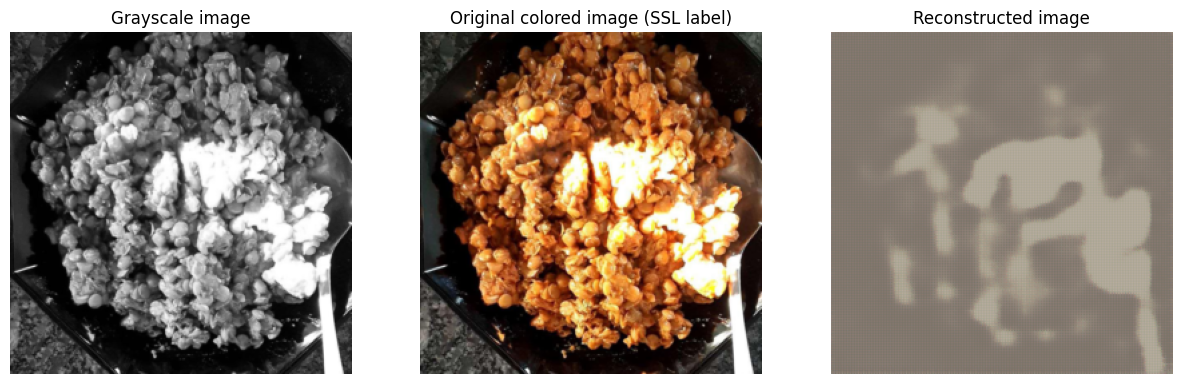

In [10]:
show_random_test_image(model, test_dataset, denormalization=True)

In [11]:

grayscale_image, color_image = test_dataset[0]

In [12]:
grayscale_image.numpy().transpose(1, 2, 0)

array([[[ 0.14154068],
        [ 0.12415856],
        [ 0.07201217],
        ...,
        [-0.56819254],
        [-0.56819254],
        [-0.7072496 ]],

       [[ 0.12415856],
        [ 0.12415856],
        [ 0.07201217],
        ...,
        [-0.65510315],
        [-0.60295683],
        [-0.72463167]],

       [[ 0.12415856],
        [ 0.10677643],
        [ 0.0893943 ],
        ...,
        [-0.7767781 ],
        [-0.75939596],
        [-0.7072496 ]],

       ...,

       [[ 2.3680186 ],
        [ 2.3731372 ],
        [ 2.3731372 ],
        ...,
        [-1.1275129 ],
        [-1.144895  ],
        [-1.1796592 ]],

       [[ 2.388493  ],
        [ 2.388493  ],
        [ 2.3813875 ],
        ...,
        [-1.1970414 ],
        [-1.1622772 ],
        [-1.1275129 ]],

       [[ 2.3844795 ],
        [ 2.3844795 ],
        [ 2.3670974 ],
        ...,
        [-1.1970414 ],
        [-1.1275129 ],
        [-1.0927486 ]]], dtype=float32)